# Twitter Sentiment Analysis - POC
---

## 6. Train a couple baseline models

Before throwing a bunch of models at the data, I first retrain the NB and LR models from the last notebook with learning curves to test whether more data improves them. The hypothesis is that they're too simple for data to improve accuracy.

At this point the proof of concept begins to merge with actual model development, as I'm starting to use the entire data for the learning curves.

In [1]:
import re
import os
import time
import json

import numpy as np
import pandas as pd
import scipy.sparse as sp

import cleanup_module_POC as Cmod

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [2]:
# time notebook
start_notebook = time.time()

# load minimally prepared X, y train subsets
raw_path = os.path.join("..","data","1_raw","sentiment140")
X = pd.read_csv(os.path.join(raw_path, "X_train.csv"))
y = pd.read_csv(os.path.join(raw_path, "y_train.csv"))

In [3]:
print(f'Dataset size: {len(X):0.0f}')
print(f'Target distribution: {sum(y["target"])/len(y):0.3f}')

Dataset size: 1197471
Target distribution: 0.499


In [4]:
X.head() # remember, original training indices saved in raw dir

,ID,username,tweet
0,1996787711,lifeischill,I went to frys to see andy and saw my BUD inst...
1,1985020349,knikkim,back home after brunch with church friends and...
2,1750930121,ginny9577,"@specialk0478 yeah she's part lab, part spanie..."
3,2063956079,kirstyhooper,kirsty is doing some ipd work!
4,1695806605,TwentyFour,@ScaryMommy Sure! My entire blogroll is ter...


In [5]:
# transform into arrays
X_array = np.array(X.iloc[:, 2]).ravel()
y_array = y.iloc[:,0].ravel()

### Pre-process with n=1,000 features

In [6]:
# processed dir
proc_dir = os.path.join("..","data","3_processed","sentiment140")

try:
    # load X_train_transformed 
    X_train_transformed = sp.load_npz(os.path.join(proc_dir, "X_train_transformed.npz"))
    print('Loading X_train_transformed.npz')
except:
    print('Preprocessing X_array with n=1000')
    preprocess_pipeline = Pipeline([
        ("document_to_wordcount", Cmod.DocumentToWordCounterTransformer()),
        ("wordcount_to_vector", Cmod.WordCounterToVectorTransformer()),
    ])
    start_pipeline = time.time()
    X_train_transformed = preprocess_pipeline.fit_transform(X_array)
    # save preprocessed data
    sp.save_npz(os.path.join(proc_dir, 'X_train_transformed.npz'), X_train_transformed)
    
    # first time approx 12 mins
    mins, secs = divmod(time.time() - start_pipeline, 60)
    print(f'Preprocessing pipeline time: {mins:0.0f} minute(s) and {secs:0.0f} second(s).')

Loading X_train_transformed.npz


In [7]:
X_train_transformed

<1197471x1001 sparse matrix of type '<class 'numpy.int32'>'
	with 10503967 stored elements in Compressed Sparse Row format>

### Train full dataset on previous POC models 

Get accuracy with the full data on these baseline models.

In [8]:
NB_clf = MultinomialNB()
score = cross_val_score(NB_clf, X_train_transformed, y_array, cv=5, verbose=2, scoring='accuracy')
print('Mean accuracy: ' + str(score.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=   0.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] ................................................. , total=   0.7s
[CV]  ................................................................
[CV] ................................................. , total=   0.7s
[CV]  ................................................................
[CV] ................................................. , total=   0.7s
[CV]  ................................................................
[CV] ................................................. , total=   0.7s
Mean accuracy: 0.75518571992841


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.9s finished


In [9]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_array, cv=5, verbose=2, scoring='accuracy')
print('Mean accuracy: ' + str(score.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  17.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.3s remaining:    0.0s


[CV] ................................................. , total=  17.9s
[CV]  ................................................................
[CV] ................................................. , total=  17.4s
[CV]  ................................................................
[CV] ................................................. , total=  16.9s
[CV]  ................................................................
[CV] ................................................. , total=  16.5s
Mean accuracy: 0.7689513976558432


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min finished


Accuracy improved a bit with more data, but how are these models learning? Is all that data necessary for this accuracy score? What about increasing the number of features?

---

## Plot Learning Curves

###  n=1,000; feed m

In [10]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def plot_learning_curves_feed_m(model, X, y, Xname):
    """Plot the learning curves for train and validation sets
       , by adding more rows (m) and keeping the number of 
       features (n) constant.
       Args:
           model: a classifier
           X: sparce matrix of features
           y: target vector
           Xname: vectorization method
       Evaluates accuracy (TODO: implement other metrics)
    """
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                          test_size=0.2, 
                                                          random_state=42)
    # train
    # change data granularity (denominator) for more data points
    data_granularity = int(X_train.shape[0]/10)
    
    xs, train_acc, valid_acc = [], [], []

    for m in range(10, X_train.shape[0], data_granularity):       
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_valid_predict = model.predict(X_valid)
        train_acc.append(accuracy_score(y_train[:m], y_train_predict))
        valid_acc.append(accuracy_score(y_valid, y_valid_predict))
        xs.append(str(m-1))

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_axes([0.0, 
                       # dynamically calculate number of x ticks
                       round(X_train.shape[0]/data_granularity, 0), 
                       0.4, 0.8])
    plt.plot(xs, np.sqrt(train_acc), 'r--', linewidth=.8, 
             label="train accuracy")
    plt.plot(xs, np.sqrt(valid_acc), 'b--', linewidth=.8, 
             label="validation accuracy")
    plt.xticks(rotation=45)
    plt.title(''.join(["Learning Rates for Training and Validation - ", 
                       Xname]), 
              fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.xlabel("Training Set Size", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()

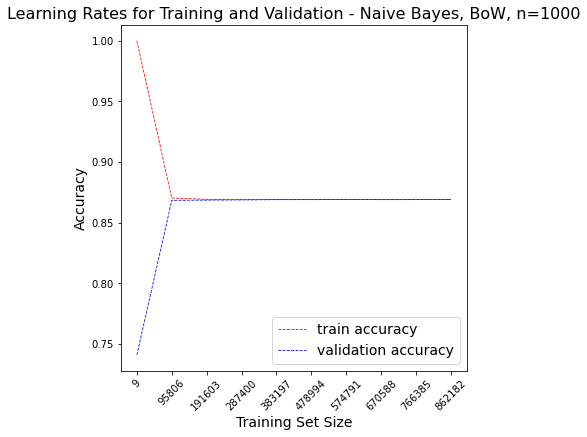

In [11]:
plot_learning_curves_feed_m(NB_clf, X_train_transformed, y_array, 
                           'Naive Bayes, BoW, n=1000')

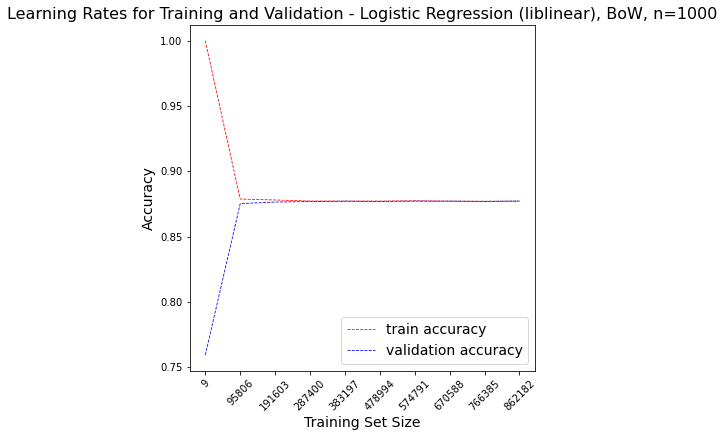

In [12]:
plot_learning_curves_feed_m(log_clf, X_train_transformed, y_array, 
                            'Logistic Regression (liblinear), BoW, n=1000')

As suspected, the models top out fairly quickly and all that data is wasted - exploring increasing the feature space now.

### m=500,000; feed n

Since it would take too long to transform the entire 1.2M dataset using a lot of features, we pair it down to ~500k since the learning curves above demonstrate how these simple models top out learning at about 95k currently. The hypothesis is that more features will improve their learning and therefore their accuracy.

In [13]:
# sample down to 500k
from sklearn.model_selection import train_test_split

X_sample, X_rest, y_sample, y_rest = train_test_split(X, y, test_size=0.58, random_state=42)

In [14]:
len(X_sample)

502937

In [15]:
# transform into arrays
X_sample_array = np.array(X_sample.iloc[:, 2]).ravel()
y_sample_array = y_sample.iloc[:,0].ravel()

In [16]:
try:
    # load X_train_transformed 
    X_train_transformed_50k = sp.load_npz(os.path.join(proc_dir, "X_train_transformed_50k.npz"))
    print('Loading X_train_transformed_50k.npz')
except:
    print('Preprocessing X_sample_array with m,n=500k,50k')
    preprocess_pipeline_50k = Pipeline([
        ("document_to_wordcount", Cmod.DocumentToWordCounterTransformer()),
        ("wordcount_to_vector", Cmod.WordCounterToVectorTransformer(vocabulary_size=50000)),
    ])
    start_pipeline = time.time()
    X_train_transformed_50k = preprocess_pipeline_50k.fit_transform(X_sample_array)
    # save preprocessed data
    sp.save_npz(os.path.join(proc_dir, 'X_train_transformed_50k.npz'), X_train_transformed_50k)
    
    # first time approx 6 mins
    mins, secs = divmod(time.time() - start_pipeline, 60)
    print(f'Preprocessing pipeline time: {mins:0.0f} minute(s) and {secs:0.0f} second(s).')

Loading X_train_transformed_50k.npz


In [17]:
X_train_transformed_50k

<502937x50001 sparse matrix of type '<class 'numpy.int32'>'
	with 5136009 stored elements in Compressed Sparse Row format>

In [18]:
def plot_learning_curves_feed_n(model, X, y, Xname):
    """Plot the learning curves for train and validation sets,
       by adding more features (n) and keeping the number of 
       rows (m) constant.
       Args:
           model: a classifier
           X: sparce matrix of features
           y: target vector
           Xname: vectorization method
       Evaluates accuracy (TODO: implement other metrics)
    """
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                          test_size=0.2, 
                                                          random_state=42)
    xs, train_acc, valid_acc = [], [], []

    # executive decision here, feeding 12 m data points
    for n in range(500, 50001, 4500):
        model.fit(X_train[:X.shape[0],:n], y_train)
        y_train_predict = model.predict(X_train[:X.shape[0],:n])
        y_valid_predict = model.predict(X_valid[:X.shape[0],:n])
        train_acc.append(accuracy_score(y_train, y_train_predict))
        valid_acc.append(accuracy_score(y_valid, y_valid_predict))
        xs.append(str(n-1))

    fig = plt.figure(figsize=(16, 6))
    ax = fig.add_axes([0.0, 
                       # dynamic x ticks would be len(range(x,y,z))
                       12, 
                       0.4, 0.8])
    plt.plot(xs, np.sqrt(train_acc), 'r--', linewidth=.8, 
             label="train accuracy")
    plt.plot(xs, np.sqrt(valid_acc), 'b--', linewidth=.8, 
             label="validation accuracy")
    plt.xticks(rotation=45)
    plt.title(''.join(["Learning Rates for Training and Validation - ", 
                       Xname]), 
              fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.xlabel("Training No. Features", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()

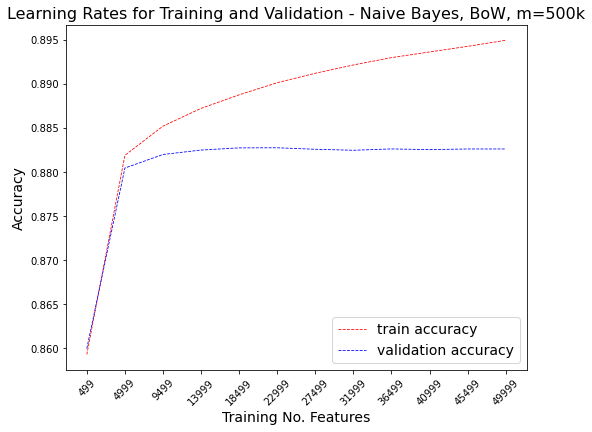

In [19]:
plot_learning_curves_feed_n(NB_clf, 
                            X_train_transformed_50k, 
                            y_sample_array, 
                            'Naive Bayes, BoW, m=500k')

Again, the Naive Bayes model is too simple to learn even with more features, it ends up just overfitting the train set after about 100k rows. The validation accuracy seems a bit higher than the model trained on 1,000 features, but I'll test the generalization with cross validation to gain a more realistic assessement.

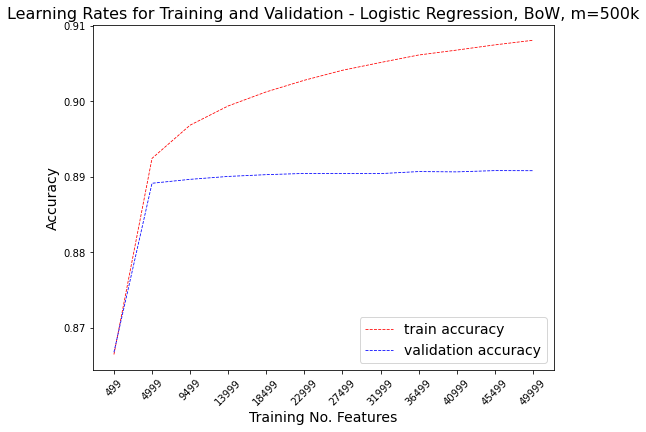

LR plot time: 5 minute(s) and 11 second(s).


In [21]:
start_plot = time.time()
plot_learning_curves_feed_n(log_clf, 
                            X_train_transformed_50k, 
                            y_sample_array, 
                            'Logistic Regression, BoW, m=500k')
mins, secs = divmod(time.time() - start_plot, 60)
print(f'LR plot time: {mins:0.0f} minute(s) and {secs:0.0f} second(s).')

The learning curve is similar, yet it learns with less data and has a tad higher accuracy. Let's test the generalization.

### Cross Validation 

In [22]:
score = cross_val_score(NB_clf, X_train_transformed_50k, y_sample_array, cv=5, verbose=3, scoring='accuracy')
print('Mean accuracy: ' + str(score.mean()))

[CV]  ................................................................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] .................................... , score=0.777, total=   0.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .................................... , score=0.777, total=   0.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] .................................... , score=0.779, total=   0.3s
[CV]  ................................................................
[CV] .................................... , score=0.778, total=   0.3s
[CV]  ................................................................
[CV] .................................... , score=0.779, total=   0.3s
Mean accuracy: 0.7777654100125664


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished


In [23]:
score = cross_val_score(log_clf, X_train_transformed_50k, y_sample_array, cv=5, verbose=3, scoring='accuracy')
print('Mean accuracy: ' + str(score.mean()))

[CV]  ................................................................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] .................................... , score=0.792, total=  45.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.2s remaining:    0.0s


[CV] .................................... , score=0.791, total=  51.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV] .................................... , score=0.793, total=  33.2s
[CV]  ................................................................
[CV] .................................... , score=0.791, total=  30.5s
[CV]  ................................................................
[CV] .................................... , score=0.794, total=  43.8s
Mean accuracy: 0.7922403837981802


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.4min finished


In [24]:
# time notebook
mins, secs = divmod(time.time() - start_notebook, 60)
print(f'Total running time: {mins:0.0f} minute(s) and {secs:0.0f} second(s).')

Total running time: 15 minute(s) and 12 second(s).


---